In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns
import threading
import os


#plt.style.use('seaborn-deep')
#plt.rc('grid', linestyle="--", color='gray')
#plt.rc('xtick', direction = 'in')
#plt.rc('ytick', direction= 'in')
# @working path
FIG_PATH     = '../tex/figs/'
WEB_FIG_PATH = '../tex/web-figs/'
DATA_PATH    = '../code/'

# @global settings
WEB_FIG_DPI  = 600
FIG_DPI      = 800
FIG_EXT      = '.pdf'
WEB_FIG_EXT  = '.png'

# @global functions
def savefig(handler,name, fig_ext = FIG_EXT, web_fig_ext = WEB_FIG_EXT):
    if name != '':
        handler.savefig(FIG_PATH + name + fig_ext, dpi = FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)
    #handler.savefig(WEB_FIG_PATH + name + web_fig_ext, dpi = WEB_FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)

Populating the interactive namespace from numpy and matplotlib


In [2]:

PC     = 648000/np.pi
KPC    = 1000*PC 
AU     = 1
MS     = 1
YR     = 2 * np.pi
Hubble_t = 13.4e9*YR
V_UNIT = 2.9784651272402163E1
KMS    = 1.0/V_UNIT
lc     = 299792.458/V_UNIT
DAY    = YR/365.25636042
HR     = DAY/24
G= 1

In [ ]:
def cross(ms, mj, aj, v):
    return 3306*ms*mj*aj*v**(-2)

den = 100.                                    
vel = np.linspace(0.1,30,100)                                                                            
t_Hub = 3.1e7*14.e9

uAU = 1.49e13

aj = 1.                                                                           

rate = 3306./3.1e18*uAU/3.1e18*uAU*t_Hub/3.1e18*vel**(-2.)*aj *  vel*1e5 * 0.1

den=[1, 100, 1e5]

fig=plt.figure(figsize=(4,3))
for d in den:
    plt.plot(vel,rate*d,label='$n=10^{' +'%.1d'%np.log10(d)+'}PC^{-3}$')
plt.yscale('log')
plt.legend()
plt.xlabel('$\sigma$ [$kms^{-1}$]')
plt.ylabel('$\Gamma_{ex}[\\tau_{Hublle}^{-1}]$')
plt.grid(True)
savefig(plt,'letter-rate')

In [ ]:
den = 100.                                    
vel = 10                                                                           
t_Hub = 3.1e7*14.e9

AU = 1.49e13

aj = 5.                                                                           

rate = 3306./3.1e18*AU/3.1e18*AU*t_Hub/3.1e18*den*vel**(-2.)*aj *  vel*1e5
print(rate)

In [3]:
def load_orbit(data,orbit_name):
    name = ['m1', 'm2', 'p', 'e', 'i', 'Omega', 'omega', 'nv']
    orbit={}
    for key, i in zip(name, range(len(name))):
        orbit.update({orbit_name+key : data[:,i]})
    return orbit

def load_incid_args(data):
    return {'v_inf': data[:,0], 'b':data[:,1], 'w':data[:,2], 'ii':data[:,3],'iphi':data[:,4]}

def load_post_scattered(data, obj_name):
    dic = {'time':data[:,0]}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 10*idx
        dic.update({'m_{' + name + '}': data[:,offset + 3],
                    'r_{' + name + '}': data[:,offset + 4],
                    'px_{' + name + '}': data[:,offset + 5],
                    'py_{' + name + '}': data[:,offset + 6],
                    'pz_{' + name + '}': data[:,offset + 7],
                    'vx_{' + name + '}': data[:,offset + 8],
                    'vy_{' + name + '}': data[:,offset + 9],
                    'vz_{' + name + '}': data[:,offset + 10]
                   })
    return dic
        
def load_closest(data, obj_name):
    dic ={}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 6*idx
        dic.update({'closest:px_{' + name + '}': data[:,offset + 0],
                    'closest:py_{' + name + '}': data[:,offset + 1],
                    'closest:pz_{' + name + '}': data[:,offset + 2],
                    'closest:vx_{' + name + '}': data[:,offset + 3],
                    'closest:vy_{' + name + '}': data[:,offset + 4],
                    'closest:vz_{' + name + '}': data[:,offset + 5]})
    return dic
        
def load_data(fname, os, objname):
    data = np.loadtxt(fname)
    
    dic = {}
    dic.update(load_orbit(data[:,os['incident-orbit-s']:os['incident-orbit-e']],'incident-orbit-') )
    #dic.update(load_incid_args(data[:,os['incident-s']:os['incident-e']]))
    
    dic.update(load_post_scattered(data[:,os['post-s']:os['post-e']], objname))
    
    if 'closest-s' and 'closest-e' in os:
        dic.update(load_closest(data[:,os['closest-s']:os['closest-e']], objname))
    
    if 'sn-orbit-s' and 'sn-orbit-e' in os:
        dic.update(load_orbit(data[:,os['sn-orbit-s']:os['sn-orbit-e']],'sn-orbit-'))
        
    if 'ss-orbit-s' and 'ss-orbit-e' in os:
        dic.update(load_orbit(data[:,os['ss-orbit-s']:os['ss-orbit-e']],'ss-orbit-'))
        
    return dic


def get_a_e(m, drx, dry, drz, dvx, dvy, dvz):
    r  = np.sqrt(drx**2 + dry**2 + drz**2)
    v2 = dvx**2 + dvy**2 + dvz**2
    v  = np.sqrt(v2)
    
    vrdot = drx*dvx + dry*dvy + drz*dvz
    
    vdfsq = (v2 - m / r)
    ex = (vdfsq * drx - vrdot * dvx)
    ey = (vdfsq * dry - vrdot * dvy) 
    ez = (vdfsq * drz - vrdot * dvz) 
    e  = np.sqrt(ex * ex + ey * ey + ez * ez) / m
    a  = -m / (v2 - 2 * m/r)
    return a, e


def calc_pair_a_e(data, pairs):
    dic = {}
    for name_i, name_j in pairs:
        mi = data['m_{' + name_i + '}']
        mj = data['m_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        dvx = data['vx_{' + name_i + '}'] - data['vx_{' + name_j + '}']
        dvy = data['vy_{' + name_i + '}'] - data['vy_{' + name_j + '}']
        dvz = data['vz_{' + name_i + '}'] - data['vz_{' + name_j + '}']
        

        a, e = get_a_e(mi + mj, dpx, dpy, dpz, dvx, dvy, dvz)
        dic.update({'a_{' + name_i + ',' + name_j + '}': a,  'e_{' + name_i + ',' + name_j + '}': e})
    return dic
        
def calc_tidal_t_scale(data, star_name, planet_name='j'):
    mp = data['m_{'+planet_name+ '}']
    rp = data['r_{'+planet_name+ '}']
    dic = {}
    for name in star_name:
        rs = data['r_{' + name + '}']
        ms = data['m_{' + name + '}']
        #s = 9.0/4/2e7*mp/ms*rs**5
        p = 9.0/4/2.5e4*ms/mp*rp**5
        a = data['a_{' + name + ',' + planet_name + '}']
        e = data['e_{' + name + ',' + planet_name + '}']
        n = np.sqrt( G*(ms+mp)/a**3)
        tau_ap = 3/n*a**5/14/e**2/p
        dic.update({'T_{' + name + ',' + planet_name + '}' : tau_ap})
    return dic

def check_collision(data, pairs):
    dic ={}
    for name_i, name_j in pairs:
        ri = data['r_{' + name_i + '}']
        rj = data['r_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        
        coll = (dpx**2 + dpy**2 + dpz**2) <= (ri + rj)**2
        
        
        data['star outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        data['planet outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        #dic.update({'coll_{' + name_i + ',' + name_j + '}': coll})
    #return dic

def classify_star_outcome(data, star_pairs):
    init_bound = np.ones(data['time'].shape, dtype=bool)
    init_unbound =np.ones(data['time'].shape, dtype=bool)
    disrupted = np.zeros(data['time'].shape, dtype=bool)
    
    for name_i, name_j in star_pairs:
        if (name_i == 's1') and (name_j == 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            init_bound = init_bound & bound
            init_unbound=init_unbound&unbound
            disrupted = np.ones(data['time'].shape, dtype=bool)
    
    
    flyby = np.ones(data['time'].shape, dtype=bool)
    
    bi_formation ={}
    for name_i, name_j in star_pairs:
        if (name_i != 's1') or (name_j != 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            
            bi_formation.update({'reunion_{' + name_i + ',' + name_j + '}': bound & init_unbound})
        
            flyby = flyby & unbound & init_bound
            
            disrupted = disrupted & unbound & init_unbound
        
    reunion = np.zeros(data['time'].shape, dtype=bool)
    for key, r in bi_formation.items():
        reunion = reunion | r
        
    data['star outcome'][reunion] = 'reunion'
    data['star outcome'][flyby]  = 'flyby'
    data['star outcome'][disrupted] = 'disrupted'
    
    #dic = {'reunion':reunion, 'flyby' : flyby, 'disrupted': disrupted}
    
    #dic.update(bi_formation)
            
    #return dic

def classify_planet_outcome(data, star_names, planet_name='j', a_final=0.1*AU):
    binary = []
    for star_name in star_names:
        a = data['a_{' + star_name + ',' + planet_name + '}']
        e = data['e_{' + star_name + ',' + planet_name + '}']
        tau_ap = data['T_{' + star_name + ',' + planet_name + '}']
        
        bound = (a > 0) & (0 <=e) & (e < 1)
        unbound = (e >= 1) & (a <= 0) 
        hot_jupiter_candi = (a*(1-e*e) < a_final) & (tau_ap < Hubble_t) 
        binary.append((star_name, bound, unbound, hot_jupiter_candi))
        
    dic={}
    for star_name1, bound1, unbound1, hj1 in binary:
        bound = bound1
        hot_jupiter = hj1
        for star_name2, bound2, unbound2, hj2 in binary:
            if(star_name1 != star_name2):
                bound = bound & unbound2
                hot_jupiter = hot_jupiter & unbound2
                
        data['planet outcome'][bound] = 'stay_{' + star_name1 + ',' + planet_name + '}'
        data['planet outcome'][hot_jupiter] = 'HJ_{' + star_name1 + ',' + planet_name + '}' 
    
        #dic.update({'stay_{' + star_name1 + ',' + planet_name + '}' : bound, 'HJ_{' + star_name1 + ',' + planet_name + '}' : hot_jupiter})
        
    ejection = np.ones(data['time'].shape, dtype=bool)
    for star_name, bound, unbound, hj in binary:
        ejection = ejection & unbound
        
    data['planet outcome'][ejection] = 'ejection_{'+planet_name+'}'
    
    
def post_process(fname, oss, objname, pairs):
    star_name = [ name for name in objname if name.startswith('s')]
    planet_name = [ name for name in objname if not name.startswith('s')]
    star_pairs = [(s1, s2) for s1, s2 in pairs if s1.startswith('s') and s2.startswith('s')]
    
    #print(star_name, planet_name, star_pairs)
    
    if os.path.exists(fname) == False:
        print('no such a file'+fname)
        return
    
    data = load_data(fname, oss, objname)
    
    data.update({'star outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update({'planet outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update(calc_pair_a_e(data, pairs))
    
    classify_star_outcome(data, star_pairs)
   
    
    for p_name in planet_name:
        data.update(calc_tidal_t_scale(data, star_name, p_name))
        classify_planet_outcome(data, star_name, p_name)
        
    check_collision(data, pairs)
    
    return data

def get_ss_final_data(df, v_inf, aj):
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}')
    
    stay = pfate == 'stay_{s,j}'
    capture = pfate == 'stay_{s1,j}'
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, capture.sum()/ntot

def get_sb_final_data(df, v_inf, aj):
    
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,s2}' ) | (sfate== 'coll_{s1,s2}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{s2,j}')
    
    stay = pfate == 'stay_{s,j}'
    
    s_capture = ( (pfate == 'stay_{s1,j}') & (sfate == 'disrupted') ) | ( (pfate == 'stay_{s2,j}') & (sfate == 'disrupted') )
    
    b_capture = ( (pfate == 'stay_{s1,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') )) | ( (pfate == 'stay_{s2,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') ))
    
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, s_capture.sum()/ntot, b_capture.sum()/ntot
    
def get_bs_final_data(df, v_inf, aj):
    
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,sb}' ) | (sfate== 'coll_{s1,sb}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{sb,j}')
    
    stay = pfate == 'stay_{s,j}'
    
    capture = pfate == 'stay_{s1,j}'
    
    trans = pfate == 'stay_{sb,j}'
    
    print('here')
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, capture.sum()/ntot, trans.sum()/ntot

def get_bb_final_data(df, v_inf, aj):
    
    p = df['incident-orbit-p']
    e = df['incident-orbit-e']
    b = p / np.sqrt(e**2 - 1)
    b_max = b[np.isfinite(b)].max()
    
    pfate = df['planet outcome']
    sfate = df['star outcome']
    
    ej = pfate == 'ejection_{j}'
    
    coll_ss = (sfate== 'coll_{s,s1}' ) | (sfate== 'coll_{s,s2}' ) | (sfate== 'coll_{s1,s2}' ) | (sfate== 'coll_{s,sb}' ) | (sfate== 'coll_{sb,s1}' )| (sfate== 'coll_{sb,s2}' )
    coll_sj = (pfate == 'coll_{s,j}') | (pfate == 'coll_{s1,j}') | (pfate == 'coll_{s2,j}')
    
    stay = pfate == 'stay_{s,j}'
    
    s_capture = ( (pfate == 'stay_{s1,j}') & (sfate == 'disrupted') ) | ( (pfate == 'stay_{s2,j}') & (sfate == 'disrupted') )
    
    b_capture = ( (pfate == 'stay_{s1,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') )) | ( (pfate == 'stay_{s2,j}') & ( (sfate == 'flyby') | (sfate == 'reunion') ))
    
    trans = pfate == 'stay_{sb,j}'
    
    ntot = len(pfate)
    
    return v_inf, aj, b_max, ej.sum()/ntot, coll_ss.sum()/ntot, coll_sj.sum()/ntot, stay.sum()/ntot, s_capture.sum()/ntot, b_capture.sum()/ntot, trans.sum()/ntot

In [4]:
import csv
def write_list_to_file(data, filename):
    """Write the list to csv file."""
    with open(filename,'w') as out:
        csv_out=csv.writer(out)
        #csv_out.writerow(['name','num'])
        for row in data:
            csv_out.writerow(row)

In [5]:
v=np.array([0.1, 3.42222222,  6.74444444,  10.06666667, 13.38888889, 16.71111111, 20.03333333, 23.35555556, 26.67777778, 30])

v_name =['0.1', '3.4', '6.7', '10.1', '13.4', '16.7', '20.0', '23.4', '26.7', '30.0']
a_j = ['0.1', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']

In [6]:
prefix = '../code/ueq/ueq-normal-ss_ss_'
#prefix = '../code/ss/solar-normal-ss_ss_'

ss_idx = {'incident-orbit-s' : 40, 'incident-orbit-e':48, 'post-s':1, 'post-e':32}

ss_names = ['s','j', 's1']

ss_pairs = [('s','j'), ('s','s1'), ('s1','j')]

df01 = pd.DataFrame(post_process(prefix+'10.1_0.1.txt', ss_idx, ss_names, ss_pairs))

df05 = pd.DataFrame(post_process(prefix+'10.1_0.5.txt', ss_idx, ss_names, ss_pairs))

df1 = pd.DataFrame(post_process(prefix+'10.1_1.0.txt', ss_idx, ss_names, ss_pairs))

df2 = pd.DataFrame(post_process(prefix+'10.1_2.0.txt', ss_idx, ss_names, ss_pairs))

df5 = pd.DataFrame(post_process(prefix+'10.1_5.0.txt', ss_idx, ss_names, ss_pairs))


#df01_3 = pd.DataFrame(post_process(prefix+'3.4_0.1.txt', ss_idx, ss_names, ss_pairs))

#df05_3 = pd.DataFrame(post_process(prefix+'3.4_0.5.txt', ss_idx, ss_names, ss_pairs))

#df1_3 = pd.DataFrame(post_process(prefix+'3.4_1.0.txt', ss_idx, ss_names, ss_pairs))

#df2_3 = pd.DataFrame(post_process(prefix+'3.4_2.0.txt', ss_idx, ss_names, ss_pairs))

#df5_3 = pd.DataFrame(post_process(prefix+'3.4_5.0.txt', ss_idx, ss_names, ss_pairs))


#df01_30 = pd.DataFrame(post_process(prefix+'30.0_0.1.txt', ss_idx, ss_names, ss_pairs))

#df05_30 = pd.DataFrame(post_process(prefix+'30.0_0.5.txt', ss_idx, ss_names, ss_pairs))

#df1_30 = pd.DataFrame(post_process(prefix+'30.0_1.0.txt', ss_idx, ss_names, ss_pairs))

#df2_30 = pd.DataFrame(post_process(prefix+'30.0_2.0.txt', ss_idx, ss_names, ss_pairs))

#df5_30 = pd.DataFrame(post_process(prefix+'30.0_5.0.txt', ss_idx, ss_names, ss_pairs))

/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: RuntimeWarning: invalid value encountered in less


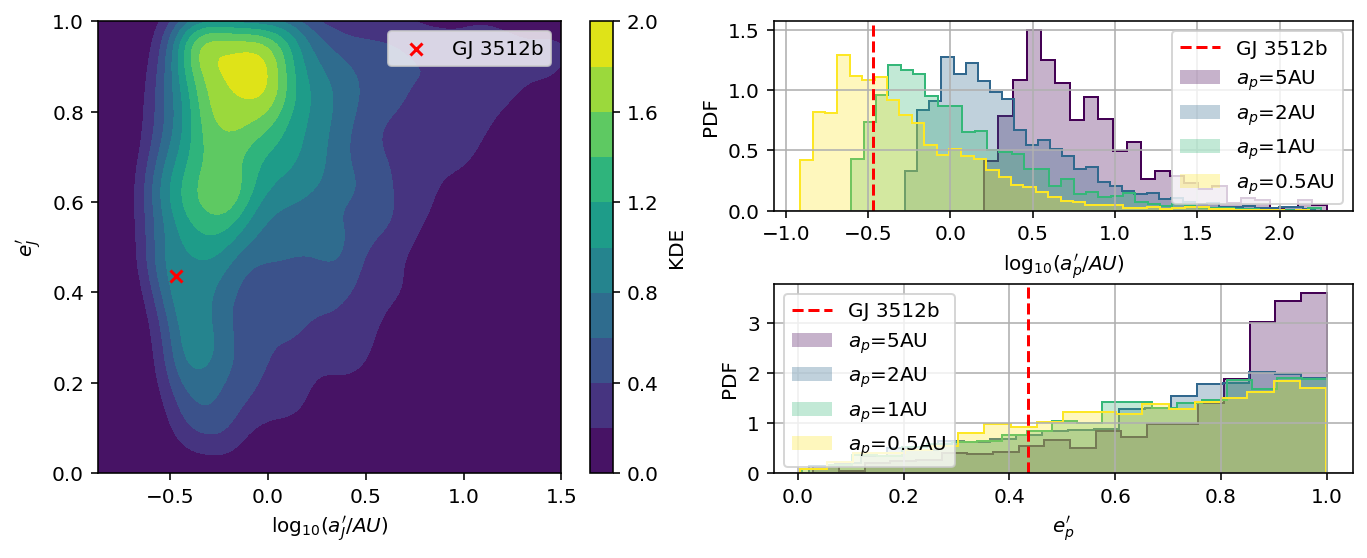

In [11]:
def show_obt_prop(name, dfs,a0s, df, a0):
    cap = df['planet outcome'] == 'stay_{s1,j}'
    a_c = df['a_{s1,j}']
    e_c = df['e_{s1,j}']
    cap = cap & (a_c[cap] < 200)
   
    fig=plt.figure(figsize=(9.6, 4))
    
    ax = fig.add_subplot(1,2,1)
    ax=sns.kdeplot(np.log10(a_c[cap]/AU), e_c[cap],clip=((-1.5, 1.5),(0,1)), cmap='viridis',shade=True,cbar=True,cbar_kws={'label': 'KDE'})
    ax.set(xlabel='$\log_{10}(a_J^\prime/AU)$', ylabel='$e_J^\prime$')
    
    ax.scatter(np.log10(0.338),0.4356,marker='x',color='r',label='GJ 3512b')
    
    ax.legend()
    
    axa = fig.add_subplot(2,2,2)
    axe = fig.add_subplot(2,2,4)
    colors = cm.viridis(np.linspace(0,1,len(dfs)))

    for df, a0, color in zip(dfs,a0s,colors):
        
        coll = df['planet outcome'] == 'coll_{s1,j}'
        cap = (df['planet outcome'] == 'stay_{s1,j}') 
        a_c = df['a_{s1,j}']
        e_c = df['e_{s1,j}']
        t=df['time']
        cap = cap & (a_c[cap] < 200)
        
        axa.hist(np.log10(a_c[cap]/AU),bins='auto',histtype='step',density=True,color=color,ls='-')
        axa.hist(np.log10(a_c[cap]/AU),bins='auto',histtype='stepfilled',density=True,color=color,alpha=0.3,label='$a_p$='+str(a0)+'AU')
        
        axe.hist((e_c[cap]),bins='auto',histtype='step',density=True,color=color)
        axe.hist((e_c[cap]),bins='auto',histtype='stepfilled',density=True,alpha=0.3,color=color,label='$a_p$='+str(a0)+'AU')
        
    axe.axvline(0.4356,ls='--',color='r',label='GJ 3512b')
    
    axe.set_xlabel('$e_p^\prime$')
    axe.set_ylabel('PDF')
    axe.grid(True)
        
    axa.axvline(np.log10(0.3380),ls='--',color='r',label='GJ 3512b')
    
    axa.set_xlabel('$\log_{10}(a_p^\prime/AU)$')
       
    axa.set_ylabel('PDF')
    axa.grid(True)
    
    axe.legend(loc=2)
    axa.legend(loc=1)
    
    plt.tight_layout(h_pad=0,w_pad=0)
    
    savefig(plt,name)
    
show_obt_prop('letter-new-ae',[df5, df2, df1, df05],[5, 2,1,0.5], df1, 1)

/home/yihan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in sqrt


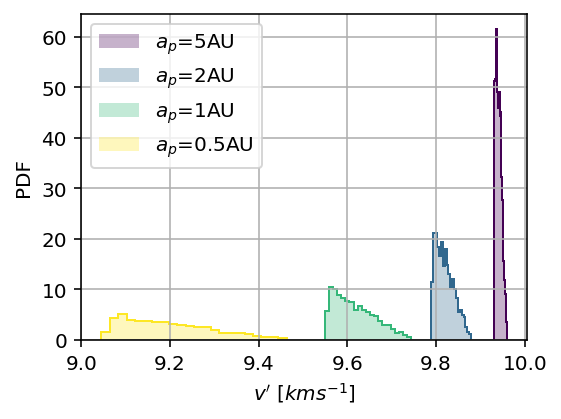

In [12]:
def v_hist(dfs,a0s,v0):
    colors = cm.viridis(np.linspace(0,1,len(dfs)))
    fig=plt.figure(figsize=(4,3))
    

    for df, a0, color in zip(dfs,a0s,colors):
        cap = df['planet outcome'] == 'stay_{s1,j}'

        ms1 = np.array(df['m_{s1}'])
        ms = np.array(df['m_{s}'])
        mj = np.array(df['m_{j}'])
        
        vxs1 = np.array(df['vx_{s1}'])
        vys1 = np.array(df['vy_{s1}'])
        vzs1 = np.array(df['vz_{s1}'])

        vxs = np.array(df['vx_{s}'])
        vys = np.array(df['vy_{s}'])
        vzs = np.array(df['vz_{s}'])
        
        vxj = np.array(df['vx_{j}'])
        vyj = np.array(df['vy_{j}'])
        vzj = np.array(df['vz_{j}'])
        
        vxcm = (vxs1*ms1 + vxj*mj)/(ms1+mj) 
        vycm = (vys1*ms1 + vyj*mj)/(ms1+mj) 
        vzcm = (vzs1*ms1 + vzj*mj)/(ms1+mj) 

        vs = np.sqrt(vxs**2 + vys**2 + vzs**2)
        
        vcm = np.sqrt(vxcm**2 + vycm**2 + vzcm**2)

        pxs1 = np.array(df['px_{s1}'])
        pys1 = np.array(df['py_{s1}'])
        pzs1 = np.array(df['pz_{s1}'])

        pxs = np.array(df['px_{s}'])
        pys = np.array(df['py_{s}'])
        pzs = np.array(df['pz_{s}'])
        
        pxj = np.array(df['px_{j}'])
        pyj = np.array(df['py_{j}'])
        pzj = np.array(df['pz_{j}'])
        
        pxcm = (pxs1*ms1 + pxj*mj)/(ms1+mj) 
        pycm = (pys1*ms1 + pyj*mj)/(ms1+mj) 
        pzcm = (pzs1*ms1 + pzj*mj)/(ms1+mj) 
        
        #pcm = np.sqrt(pxcm**2 + pycm**2 + pzcm**2)

        dpx = pxcm - pxs
        dpy = pycm - pys
        dpz = pzcm - pzs

        r = np.sqrt(dpx**2 + dpy**2 + dpz**2)

        #a_cm, e_cm = get_a_e(ms+ms1+mj, dpx, dpy, dpz, dvx, dvy, dvz)
        
        a_c = df['a_{s1,j}']
        #e_c = df['e_{s1,j}']
        cap = cap & (a_c[cap] < 200)

        dvxcm = vxcm - vxs
        dvycm = vycm - vys
        dvzcm = vzcm - vzs

        #dvcm=np.sqrt(dvxcm**2 + dvycm**2 + dvzcm**2)

        new_v = np.sqrt(vcm**2 -G*ms**2/(ms+ms1+mj)/r * 2) 

        new_v = new_v*(ms+ms1+mj)/ms


        #print((0.5*ms1*(ms+mj)/(ms1+ms+mj)*v0**2-G*ms*mj/a0/2))

        #Ek = 0.5*ms1*(vxs1**2 + vys1**2 + vzs1**2)+0.5*mj*(vxj**2 + vyj**2 + vzj**2)+0.5*ms*(vxs**2 + vys**2 + vzs**2)

        #def dis(x,y,z,x1,y1,z1):
        #    dx = x-x1
        #    dy = y-y1
        #    dz = z-z1
        #    return np.sqrt(dx**2+dy**2+dz**2)

        #Ep = G*( -ms*mj/dis(pxs,pys,pzs,pxj,pyj,pzj) - ms*ms1/dis(pxs,pys,pzs,pxs1,pys1,pzs1) - ms1*mj/dis(pxs1,pys1,pzs1,pxj,pyj,pzj))

        #print(Ek+Ep)
        
        plt.hist((new_v[cap]/KMS),bins='auto',histtype='step',density=True,color=color)
        plt.hist((new_v[cap]/KMS),bins='auto',histtype='stepfilled',density=True,alpha=0.3,color=color,label='$a_{p}$='+str(a0)+'AU')
    plt.legend(loc=0)
    plt.xlabel('$v^\prime$ [$kms^{-1}$]')
    plt.ylabel('PDF')
        #plt.xlim([0,12])
    plt.grid(True)
    savefig(plt,'letter-v')
     
v_hist([df5,df2,df1,df05], [5,2,1,0.5], 10.1*KMS)

In [ ]:
def show_b(dfs,a_s, v=10.1*KMS):
    
    for df, a0 in zip(dfs, a_s):
        cap = df['planet outcome'] == 'stay_{s1,j}'
        a_c = df['a_{s1,j}']
        e_c = df['e_{s1,j}']
    
        obt_n = 'incident-orbit-'
    
        e = df[obt_n+'e']
        p = df[obt_n+'p']
        
        re = p/(1+e)
        
        b = p/np.sqrt(e**2-1)
    

        cap = cap & (a_c[cap] < 200)
        plt.hist(b[cap],bins='auto',histtype='step',density=True)
        plt.hist(b[cap],bins='auto',histtype='stepfilled',label='$a_p$='+str(a0)+'AU',density=True,alpha=0.8)
    plt.legend()
    plt.xlabel('$re_{ex}$ [AU]')
    plt.ylabel('PDF')
    plt.grid(True)
    savefig(plt,'explore_re')
    
    
show_b([df01,df05,df1,df2,df5],[0.1,0.5,1,2,5])

In [ ]:
def show_E(dfs,a_s, v_inf=10.1*KMS):
    
    num = len(dfs)
    fig =plt.figure(figsize=(4,3*num))
    
    axs=[]
    for i in range(num):
        axs.append(fig.add_subplot(num,1,i+1))
        
    for df, a0, ax in zip(dfs, a_s, axs):
        ms = df['m_{s}']
        mp = df['m_{j}']
        ms1=df['m_{s1}']
        
        v_tcm = v_inf*ms1/(ms1+ms+mp)
        
        v_scm = -v_tcm
        
        vs1 = v_inf - v_tcm
        
        Ekscm = 0.5*(ms+mp)*v_scm**2
        
        Eks1 = 0.5*ms1*vs1**2
        
        Eb = -G*ms*mp/2/a0
        
        vxs = df['vx_{s}']
        vys = df['vy_{s}']
        vzs = df['vz_{s}']
        
        vxs1 = df['vx_{s1}']
        vys1 = df['vy_{s1}']
        vzs1 = df['vz_{s1}']
        
        vxj = df['vx_{j}']
        vyj = df['vy_{j}']
        vzj = df['vz_{j}']
        
        vxcm = (vxs1*ms1 + vxj*mp)/(ms1+mp) 
        vycm = (vys1*ms1 + vyj*mp)/(ms1+mp) 
        vzcm = (vzs1*ms1 + vzj*mp)/(ms1+mp) 
        
        vcm = np.sqrt(vxcm**2 + vycm**2 + vzcm**2)
        
        
        
        vs = np.sqrt(vxs**2+vys**2+vzs**2)
        Eks = 0.5*ms*vs**2
        
        Eks1cm = 0.5*(ms1+mp)*vcm**2
        
        a_c = df['a_{s1,j}']
        e_c = df['e_{s1,j}']
        
        Eb_prime = -G*ms1*mp/2/a_c
        
        
        pxs = df['px_{s}']
        pys = df['py_{s}']
        pzs = df['pz_{s}']
        
        pxs1 = df['px_{s1}']
        pys1 = df['py_{s1}']
        pzs1 = df['pz_{s1}']
        
        pxj = df['px_{j}']
        pyj = df['py_{j}']
        pzj = df['pz_{j}']
        
        pxcm = (pxs1*ms1 + pxj*mp)/(ms1+mp) 
        pycm = (pys1*ms1 + pyj*mp)/(ms1+mp) 
        pzcm = (pzs1*ms1 + pzj*mp)/(ms1+mp) 
        
        dx = pxcm - pxs
        dy = pycm - pys
        dz = pzcm - pzs
        
        dr = np.sqrt(dx**2+dy**2+dz**2)
        
        Ep = -G*ms*(ms1+mp)/dr
        
        cap = df['planet outcome'] == 'stay_{s1,j}'
        
        obt_n = 'incident-orbit-'
    
        e = df[obt_n+'e']
        p = df[obt_n+'p']
        
        re = p/(1+e)
        
        b = p/np.sqrt(e**2-1)
    

        cap = cap & (a_c[cap] < 200)
        
        
        #plt.hist(Eks[cap],bins='auto',histtype='step',density=True)
        ax.plot(Eks[cap],label='$E_{s}$',color='orange')
        
        ax.plot(Eks1cm[cap],label='$E_{s1,cm}$',color='g')
        
        ax.plot(Eb_prime[cap],label='$B_{s1,cm}$',color='b')
        
        ax.plot(Ep[cap],label='$E_p$',color='r')
        
        
        
        ax.axhline(Ekscm[0],label='$E_{s,cm}$',color='orange',ls='--')
        ax.axhline(Eks1[0],label='$E_{s1}$',color='g',ls='--')
        ax.axhline(Eb[0],label='$B_{s,cm}$',color='b',ls='--')
        
        ax.legend()
        ax.set_xlabel('samples for'+'$a_p$='+str(a0)+'AU')
        ax.set_ylabel('Energy [?]')
        ax.set_xticklabels([])
        ax.grid(True)
        
    plt.tight_layout()
    savefig(plt,'explore_E')
    
    
show_E([df5,df2,df1,df05,df01],[5,2,1,0.5,0.1])

In [ ]:
prefix = '../code/ueq/ueq-normal-ss_ss_'

ss_idx = {'incident-orbit-s' : 40, 'incident-orbit-e':48, 'post-s':1, 'post-e':32}

ss_names = ['s','j', 's1']

ss_pairs = [('s','j'), ('s','s1'), ('s1','j')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        print(vv, aj)
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', ss_idx, ss_names, ss_pairs))
                          
        if df.empty != True:
            s = get_ss_final_data(df, float(vv), float(aj))
            stat.append(s)

In [ ]:
prefix = '../code/sb/dwarf-normal-sb_sb_'

sb_idx = {'incident-orbit-s' : 50, 'incident-orbit-e':58, 'post-s':1, 'post-e':42}

sb_names = ['s','j', 's1', 's2']

sb_pairs = [('s','j'), ('s','s1'),('s','s2'), ('s1','j'),('s2','j'),('s1','s2')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        print(vv, aj)
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', sb_idx, sb_names, sb_pairs))
        if df.empty != True:
            s = get_sb_final_data(df, float(vv), float(aj))
            stat.append(s)

In [ ]:
prefix = '../code/bs/dwarf-normal-bs_bs_'

bs_idx = {'incident-orbit-s' : 50, 'incident-orbit-e':58, 'post-s':1, 'post-e':42}

bs_names = ['s','sb', 'j', 's1']

bs_pairs = [('s','j'), ('s','s1'),('s','sb'), ('s1','j'),('sb','j'),('s1','sb')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        print(vv, aj)
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', bs_idx, bs_names, bs_pairs))
        if df.empty != True:
            s = get_bs_final_data(df, float(vv), float(aj))
            stat.append(s)
        
#df = pd.DataFrame(post_process(prefix+'0.1_0.1.txt', bs_idx, bs_names, bs_pairs))
#get_bs_final_data(df, float(vv), float(aj))

In [ ]:
prefix = '../code/bb/dwarf-normal-bb_bb_'

bb_idx = {'incident-orbit-s' : 60, 'incident-orbit-e':68, 'post-s':1, 'post-e':52}

bb_names = ['s','sb', 'j', 's1','s2']

bb_pairs = [('s','j'), ('s','s1'),('s','sb'), ('s1','j'),('sb','j'),('sb','s1'),('s','s2'),('s2','j'),('s1','s2'),('sb','s2')]
    
stat = []
for vv in v_name:
    for aj in a_j:
        print(vv, aj)
        df = pd.DataFrame(post_process(prefix+vv+'_'+aj+'.txt', bb_idx, bb_names, bb_pairs))
        if df.empty != True:
            s = get_bb_final_data(df, float(vv), float(aj))
            stat.append(s)


In [ ]:
write_list_to_file(stat, 'ueq-single-single.csv')

In [ ]:
def a_h(sigma, M):
    return G*M/sigma**2

a_h_02 = a_h(v_inf, 0.2)

a_p_max_02 = a_h_02 / stab_ratio

a_h_1 = a_h(v_inf, 1)

a_p_max_1 = a_h_1 / stab_ratio


plt.plot(v_inf/KMS, a_p_max_02/AU)
plt.axhline(5)
plt.axhline(0.1)
plt.xscale('log')
plt.yscale('log')

In [ ]:
ssdf=pd.DataFrame(pd.read_csv('solar/single-single.csv', skipinitialspace=True))
dssdf=pd.DataFrame(pd.read_csv('solar/d-single-single.csv', skipinitialspace=True))

sbdf=pd.DataFrame(pd.read_csv('solar/single-binary.csv',skipinitialspace=True))
dsbdf=pd.DataFrame(pd.read_csv('solar/d-single-binary.csv',skipinitialspace=True))

bsdf=pd.DataFrame(pd.read_csv('solar/binary-single.csv',skipinitialspace=True))
dbsdf=pd.DataFrame(pd.read_csv('solar/d-binary-single.csv',skipinitialspace=True))

bbdf=pd.DataFrame(pd.read_csv('solar/binary-binary.csv',skipinitialspace=True))
dbbdf=pd.DataFrame(pd.read_csv('solar/d-binary-binary.csv',skipinitialspace=True))

In [ ]:
ueqssdf = pd.DataFrame(pd.read_csv('solar/ueq-single-single.csv',skipinitialspace=True))

In [ ]:
def fitting(x,a,b):
    return a/x**b

def logave(a,b,c,d):
    return 10** ((np.log10(a) + np.log10(b) + np.log10(c) + np.log10(d))/4)

from scipy import optimize

def end_c(df,aj=1):
    N=1000000
    
    mask = df['aj']==aj
    
    x = df['vel'][mask]
    if 'cap' in df:
        nx = N*df['cap']
        er = np.sqrt(nx)/N
        y= (np.pi*df['b_max']**2*df['cap'])[mask]
        err=(np.pi*df['b_max']**2*er)[mask]
        return x,y, err
    else:
        nx = N*df['b_cap']
        er = np.sqrt(nx)/N
        y=(np.pi*df['b_max']**2*df['b_cap'])[mask]
        err=(np.pi*df['b_max']**2*er)[mask]
        return x, y, err
    
ueqx ,ueqy, ueqe = end_c(ueqssdf)
#ssx, ssy, sse=end_c(ssdf)
#sbx, sby, sbe=end_c(sbdf)
#bsx, bsy, bse=end_c(bsdf)
#bbx, bby, bbe=end_c(bbdf)

#dssx, dssy, dsse = end_c(dssdf)
#dsbx, dsby, dsbe=end_c(dsbdf)
#dbsx, dbsy, dbse=end_c(dbsdf)
#dbbx, dbby, dbbe=end_c(dbbdf)

#ave_sy = logave(np.array(ssy), np.array(sby), np.array(bsy), np.array(bby))

#ave_dy = logave(np.array(dssy), np.array(dsby), np.array(dbsy), np.array(dbby))

fig=plt.figure(figsize=(4,3))

plt.plot(ueqx, ueqy, 'rx')
#plt.plot(ssx,ssy,'.',label='single + single')
#plt.plot(sbx,sby,'.',label='binary + single')
#plt.plot(bsx,bsy,'.',label='single + binary')
#plt.plot(bbx,bby,'.',label='binary + binary')

#plt.plot(dssx,dssy,'x',label='dwarf 1+1')
#plt.plot(dsbx,dsby,'x',label='dwarf 2+1')
#plt.plot(dbsx,dbsy,'x',label='dwarf 1+2')
#plt.plot(dbbx,dbby,'x',label='dwarf 2+2')

#a,b = optimize.curve_fit(fitting, ssx, ave_sy, p0=[10**4, 2], check_finite=True,absolute_sigma=True)

a,b = optimize.curve_fit(fitting, ueqx, ueqy, p0=[10**4, 2], check_finite=True,absolute_sigma=True)

#da,db = optimize.curve_fit(fitting, dssx, ave_dy, p0=[0.2*10**4, 2], check_finite=True,absolute_sigma=True)

print(a,b)
v=np.linspace(0.1,30,1000)

plt.plot(v, a[0]/v**a[1], 'k--', label='$\sim 1/v^{2.03}$')

#plt.plot(v, da[0]/v**da[1], 'k--')

plt.yscale('log')

#plt.xscale('log')
plt.legend(loc=1,ncol=1)
plt.xlabel('$v_\infty$ [$kms^{-1}$]')
plt.ylabel('$\sigma_{ex}$ [$AU^2$]')
plt.grid(True)
#savefig(plt,'capture')

In [ ]:
aj=[0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
c=[]
ec=[]
p=[]
ep=[]

for a in aj:
    #ssx, ssy, sse=end_c(ssdf,a)
    
    #ssx, ssy, sse=end_c(ssdf,a)
    #sbx, sby, sbe=end_c(sbdf,a)
    #bsx, bsy, bse=end_c(bsdf,a)
    #bbx, bby, bbe=end_c(bbdf,a)
    
   # ave_sy = logave(np.array(ssy), np.array(sby), np.array(bsy), np.array(bby))
    ueqx ,ueqy, ueqe = end_c(ueqssdf,a)
    
    af,bf = optimize.curve_fit(fitting, ueqx, ueqy,p0=[10**4, 2])
    c.append(af[0])
    p.append(af[1])
    ec.append(bf[0][0])
    ep.append(bf[1][1])

     
fig = plt.figure(figsize=(4,3))
ax=fig.add_subplot(2,1,1)
ax.plot(aj,p,'.')    
ax.set_ylim([1.5,2.5])

#empty_string_labels = ['']*len(labels)
ax.set_xticklabels('')
ax.set_ylabel(r'$\alpha$')
plt.grid(True)

ax=fig.add_subplot(2,1,2)
ax.plot(aj,c,'.')   
fit_p=np.polyfit(aj,c,1)
print(fit_p)

ax.plot(aj,np.array(aj)*fit_p[0]+fit_p[1],'--')
ax.set_xlabel('$a_j$ [AU]')
ax.set_ylabel('C')
plt.legend()
plt.tight_layout(h_pad=0)
plt.grid(True)
#savefig(plt,'capture-fitting')
print(c,p)

In [ ]:

def show_fitting(df):
    fig = plt.figure(figsize=(7,3))
    ax = fig.add_subplot(1,2,1)
    
    ueqx ,ueqy, ueqe = end_c(df)


    ax.plot(ueqx, ueqy, 'x')
    


    a,b = optimize.curve_fit(fitting, ueqx, ueqy, p0=[10**4, 2], check_finite=True,absolute_sigma=True)
    
    
    v=np.linspace(0.1,30,1000)

    
    
    #ax.plot(v, a[0]/v**a[1],ls='-', lw=3,label='$\sim 1/v^{2.03}$',color='g',alpha=0.8)
    
    ax.plot(v, a[0]/v**a[1],ls='--',label='$\sim 1/v^{2.03}$')
    
    plt.yscale('log')


    plt.legend(loc=1,ncol=1)
    plt.xlabel('$v_\infty$ [$kms^{-1}$]')
    plt.ylabel('$\sigma_{ex}$ [$AU^2$]')
    plt.grid(True)
    
    
    ax = fig.add_subplot(2,2,2)
    
    aj=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
    c=[]
    ec=[]
    p=[]
    ep=[]

    for a in aj:
    
        ueqx ,ueqy, ueqe = end_c(df,a)
    
        af,bf = optimize.curve_fit(fitting, ueqx, ueqy,p0=[10**4, 2])
        c.append(af[0])
        p.append(af[1])
        ec.append(bf[0][0])
        ep.append(bf[1][1])

     

    ax.plot(aj,p,'.')    
    ax.set_ylim([1.5,2.5])

    ax.set_xticklabels('')
    ax.set_ylabel(r'$\alpha$')
    plt.grid(True)
    
    ax=fig.add_subplot(2,2,4)
    ax.plot(aj,np.array(c),'.')   
    fit_p=np.polyfit(aj,c,1)

    
    ax.plot(aj,(np.array(aj)*fit_p[0]+fit_p[1]),'--')
    ax.set_xlabel('$a_p$ [AU]')
    ax.set_ylabel('$C$')
    
    
    plt.tight_layout(h_pad=0)
    plt.grid(True)
    savefig(plt,'letter-fitting')
    
show_fitting(ueqssdf)

In [ ]:
def v_c_1_1(ms, mj, aj, ms1):
    m_s = ms+mj
    m_i = ms1
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj))

def v_c_1_2(ms, mj, aj, ms1, ms2, a_s):
    m_s = ms+mj
    m_i = ms1+ms2
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj+ms1*ms2/a_s))

def v_c_2_1(ms, mb, mj, aj, ms1, a_s):
    m_s = ms+mj+mb
    m_i = ms1
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj + (ms+mj)*mb/a_s))

def v_c_2_2(ms, mb, mj, aj, ms1, ms2, a_s):
    m_s = ms+mj+mb
    m_i = ms1+ms2
    u = m_s*m_i/(m_s + m_i)
    return np.sqrt(1/u*(ms*mj/aj + (ms+mj)*mb/a_s + ms1*ms2/a_s))


In [ ]:
v_c_1_1(1,1e-3,0.5,1)/KMS

In [ ]:
def event_title(e):
    if e == 'cap':
        return 'capture'
    elif e == 's_cap':
        return 'single capture'
    elif e == 'b_cap':
        return 'binary capture'
    elif e == 'coll':
        return 'collision'
    elif e == 'trans':
        return 'planet transfer'
    else:
        return e

def get_ratio(df, e):
    if e == 'coll':
        return np.array(df['s_coll']) +  np.array(df['s_coll'])
    else:
        return np.array(df[e])
    
def get_level(sigmas):
    max_s = 0
    min_s = 10**100
    for s in sigmas:
        max_s = max(max_s,s.max())
        min_s = min(min_s,s.min())
    
    if min_s > 0:
        min_s = int(min_s)
    else:
        min_s = int(min_s)-1
        
    if max_s > 0:
        max_s = int(max_s)+1
    else:
        max_s = int(max_s)
    return np.linspace(min_s, max_s, 2*max_s - 2*min_s+1)

def show_cross_section(name,df, event):
    x=np.array(df['aj'])
    y=(np.array(df['vel']))
    
    xlabel='$a_j$ [AU]'
    ylabel='$v_\infty$ [$kms^{-1}$]'
    
    delta = 0.1
    
    C = np.array(df['b_max'])**2*np.pi
    
    labels = [event_title(e) for e in event]
    
    sigmas = [np.log10(C*get_ratio(df, e) + delta) for e in event]
        
    levels = get_level(sigmas)
  
    base_width = 2
    base_height= 2
    
    panel_num = len(event)
    
    row_num = int(((panel_num+1)/2))
    
    fig=plt.figure(figsize=(base_width*2, base_height*row_num))
    
    axs = [fig.add_subplot(row_num, 2, i+1) for i in range(panel_num)]
    
    for ax, sigma, label, i in zip(axs, sigmas, labels, range(panel_num)):
        im = ax.tricontourf(x,y, sigma, levels=levels, vmax=levels.max(), vmin=levels.min(),cmap='Spectral')
        
        ax.text(.5, 25, label,bbox=dict(facecolor='w', edgecolor='none', boxstyle='round',alpha=0.5),fontsize=10)
        if i%2 == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_yticklabels('')
            
        if int(i/2) == row_num-1 or ((int(i/2) == row_num-2) and (i == panel_num - 2)):
            ax.set_xlabel(xlabel)
        else:
            ax.set_xticklabels('')
        ax.grid(True)
      
    cbar_ax = fig.add_axes([0.92, 0.15, 0.05, 0.7])
    cb = plt.colorbar(im,cax=cbar_ax)
    cb.set_label('$\log_{10}(\sigma/AU^2)$') 
    
    plt.subplots_adjust(wspace=0, hspace=0)
    #plt.tight_layout(h_pad=0,w_pad=0)
    
    savefig(plt, name)
    
#show_cross_section('d-solar-normal-ss',dssdf,['ejection','cap','coll'])
#show_cross_section('d-solar-normal-sb',dsbdf,['ejection','s_cap','b_cap','coll'])
#show_cross_section('d-solar-normal-bs',dbsdf,['ejection','cap','trans','coll'])
#show_cross_section('d-solar-normal-bb',dbbdf,['ejection','s_cap','b_cap','trans','coll'])
show_cross_section('ueq-normal-ss',ueqssdf,['ejection','cap','coll'])

In [ ]:
print(df['vel'])

In [ ]:
sns.relplot(x='vel',y='aj',hue='ejection',data=df)

In [ ]:
int(2.6)